## Cálculo da exposição aos fatores de risco - fundos que compõem o IHFA

## Long e Short Positions 

## IHFA = Índice de Hedge Funds Anbima

### Monica Barros - 21/04/2021

In [1]:
#!pip install cvxopt
#!pip install pytest
#!pip install cvxpy   #<--- Módulo para otimização
#!pip install openpyxl
#!pip install pytz

In [328]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
pd.set_option('max_colwidth', 200)  # Altera largura máxima das colunas
pd.options.display.max_columns = None  # Exibe todas as colunas
pd.set_option('display.max_colwidth', None)

import seaborn as sns; 
sns.set(rc={'figure.figsize':(17,6)})

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

import os
import datetime
from dateutil.relativedelta import relativedelta
import time
from time import perf_counter

import glob
import pickle

#!pip install openpyxl
from openpyxl import Workbook

#!pip install pytz
import pytz
local_tz = pytz.timezone('America/Sao_Paulo')

In [3]:
import cvxpy as cp
import scipy

In [4]:
dir_cadastro =  '/home/jovyan/work/@Fund_Eval/CVM/Cadastro/'
dir_cot_fundos = '/home/jovyan/work/@Fund_Eval/CVM/Diario/'
dir_fat_risco = '/home/jovyan/work/@Fund_Eval/@fatores_risco/'

In [5]:
os.chdir(dir_fat_risco)
#os.listdir()

### Define data de hoje (para incluir nos arquivos de saida)

In [6]:
data_hoje = datetime.datetime.now(tz = local_tz)
# Converte para string (incluindo hora e minuto - útil se for rodar várias vezes no mesmo dia para testes)
data_hoje = data_hoje.strftime("%Y_%m_%d_%H%M")

dd = datetime.datetime.now(tz = local_tz).strftime('%Y%m%d')

## Leitura de fatores de risco e dados de fundos (valor da quota, PL, ...)

In [7]:
df_fat = pd.read_pickle('fatores_de_risco_ready_to_go_20210226.pkl')

In [8]:
df_fat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1514 entries, 2017-01-01 to 2021-02-25
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   YEAR                  1514 non-null   int64  
 1   MONTH                 1514 non-null   int64  
 2   SP500                 1044 non-null   float64
 3   NASDAQ                1045 non-null   float64
 4   Dow_Jones_Comp_Avg    1044 non-null   float64
 5   Dow_Jones_Ind_Avg     1044 non-null   float64
 6   Dow_Jones_Transp_Avg  1044 non-null   float64
 7   Wilshire5000          1044 non-null   float64
 8   VIX                   1044 non-null   float64
 9   OIL_Brent             1056 non-null   float64
 10  OIL_WTI               1035 non-null   float64
 11  10yr_Treasury         1036 non-null   float64
 12  5yr_Treasury          1036 non-null   float64
 13  1yr_Treasury          1036 non-null   float64
 14  3mo_Treasury          1036 non-null   float64
 15  ANB

In [9]:
df_fundos = pd.read_pickle('fundos_mm_ready_to_go_20210223.pkl')
#df_fundos = pd.read_pickle('small_fundos_mm_ready_to_go_20210223.pkl')

In [10]:
df_fundos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 2017-01-02 to 2021-02-12
Columns: 41067 entries, NR_COTST 00.068.305/0001-35 to VL_QUOTA 97.929.213/0001-34
dtypes: float64(41067)
memory usage: 323.7+ MB


In [11]:
print(df_fat.shape)
print(df_fundos.shape)

(1514, 38)
(1033, 41067)


## Converter índice de df_fundos para datetime

In [12]:
df_fundos.index = pd.to_datetime(df_fundos.index)

In [13]:
df_fundos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1033 entries, 2017-01-02 to 2021-02-12
Columns: 41067 entries, NR_COTST 00.068.305/0001-35 to VL_QUOTA 97.929.213/0001-34
dtypes: float64(41067)
memory usage: 323.7 MB


## Cria df apenas com valores das quotas

In [14]:
cols_quota = [col for col in df_fundos.columns if 'VL_QUOTA' in col]

In [15]:
df_quota = df_fundos[cols_quota]

In [16]:
# Calcula número de missings em cada coluna
# len(df_quota) - df_quota.count()
df_quota.isna().sum()

VL_QUOTA 00.068.305/0001-35       0
VL_QUOTA 00.071.477/0001-68       0
VL_QUOTA 00.073.041/0001-08       0
VL_QUOTA 00.083.181/0001-67       1
VL_QUOTA 00.089.915/0001-15       0
                               ... 
VL_QUOTA 97.548.162/0001-09    1012
VL_QUOTA 97.548.167/0001-23       0
VL_QUOTA 97.711.812/0001-87     740
VL_QUOTA 97.929.197/0001-80       0
VL_QUOTA 97.929.213/0001-34       0
Length: 13689, dtype: int64

## Concatenar fatores de risco e quotas de fundos

In [17]:
df_all=pd.concat([df_fat,df_quota], axis = 1)

In [18]:
print(df_all.shape)

(1514, 13727)


## Elimina dias em que Ibovespa não foi negociado (fins de semana e feriados brasileiros)

In [19]:
df_all = df_all[df_all['GM366_IBVSP366'].notna()]
df_all.shape

(1020, 13727)

In [20]:
df_all.head(3)

YEAR  MONTH    SP500   NASDAQ  Dow_Jones_Comp_Avg  \
2017-01-02  2017      1      NaN      NaN                 NaN   
2017-01-03  2017      1  2257.83  5429.08             6917.33   
2017-01-04  2017      1  2270.75  5477.00             6952.31   

            Dow_Jones_Ind_Avg  Dow_Jones_Transp_Avg  Wilshire5000    VIX  \
2017-01-02                NaN                   NaN           NaN    NaN   
2017-01-03           19881.76               9023.86      23465.37  12.85   
2017-01-04           19942.16               9115.72      23639.16  11.85   

            OIL_Brent  ...  VL_QUOTA 97.525.430/0001-69  \
2017-01-02        NaN  ...                  1486.778966   
2017-01-03      55.05  ...                  1487.623452   
2017-01-04      54.57  ...                  1488.408886   

            VL_QUOTA 97.525.452/0001-29  VL_QUOTA 97.525.454/0001-18  \
2017-01-02                  2109.170473                   172.376222   
2017-01-03                  2110.474066                   172.514624   
2017-01-04                  2111.778259                   172.278389   

            VL_QUOTA 97.543.626/0001-86  VL_QUOTA 97.543.707/0001-86  \
2017-01-02                          NaN                     1.058470   
2017-01-03                          NaN                     1.097389   
2017-01-04                          NaN                     1.097418   

            VL_QUOTA 97.548.162/0001-09  VL_QUOTA 97.548.167/0001-23  \
2017-01-02                     2.304889                     2.132760   
2017-01-03                     2.286750                     2.131012   
2017-01-04                     2.266704                     2.128621   

            VL_QUOTA 97.711.812/0001-87  VL_QUOTA 97.929.197/0001-80  \
2017-01-02                     2.491731                     2.439919   
2017-01-03                     2.536513                     2.463890   
2017-01-04                     2.536816                     2.463123   

            VL_QUOTA 97.929.213/0001-34  
2017-01-02                     7.396478  
2017-01-03                     7.403134  
2017-01-04                     7.384956  

[3 rows x 13727 columns]

## Remove últimas 2 linhas (valores faltantes)

In [21]:
df_all = df_all.iloc[:-2]

In [22]:
df_all.tail(3)

YEAR  MONTH    SP500    NASDAQ  Dow_Jones_Comp_Avg  \
2021-02-18  2021      2  3913.97  13865.36            10386.65   
2021-02-19  2021      2  3906.71  13874.46            10415.12   
2021-02-22  2021      2  3876.50  13533.05            10416.13   

            Dow_Jones_Ind_Avg  Dow_Jones_Transp_Avg  Wilshire5000    VIX  \
2021-02-18           31493.34              13049.70      41136.51  22.49   
2021-02-19           31494.32              13274.21      41179.73  22.05   
2021-02-22           31521.69              13381.42      40801.02  23.45   

            OIL_Brent  ...  VL_QUOTA 97.525.430/0001-69  \
2021-02-18      64.09  ...                          NaN   
2021-02-19      62.84  ...                          NaN   
2021-02-22      64.73  ...                          NaN   

            VL_QUOTA 97.525.452/0001-29  VL_QUOTA 97.525.454/0001-18  \
2021-02-18                          NaN                          NaN   
2021-02-19                          NaN                          NaN   
2021-02-22                          NaN                          NaN   

            VL_QUOTA 97.543.626/0001-86  VL_QUOTA 97.543.707/0001-86  \
2021-02-18                          NaN                          NaN   
2021-02-19                          NaN                          NaN   
2021-02-22                          NaN                          NaN   

            VL_QUOTA 97.548.162/0001-09  VL_QUOTA 97.548.167/0001-23  \
2021-02-18                          NaN                          NaN   
2021-02-19                          NaN                          NaN   
2021-02-22                          NaN                          NaN   

            VL_QUOTA 97.711.812/0001-87  VL_QUOTA 97.929.197/0001-80  \
2021-02-18                          NaN                          NaN   
2021-02-19                          NaN                          NaN   
2021-02-22                          NaN                          NaN   

            VL_QUOTA 97.929.213/0001-34  
2021-02-18                          NaN  
2021-02-19                          NaN  
2021-02-22                          NaN  

[3 rows x 13727 columns]

## Leitura do cadastro de fundos

In [23]:
df_cadastro = pd.read_pickle(dir_cadastro+'cadastro_fundos_multimercado_ready_to_go_20210219.pkl')

In [24]:
#df.fillna(method='ffill')

# Dataframe de retornos

In [25]:
df_return = df_all.pct_change(1)

In [26]:
df_return.head(3)

YEAR  MONTH     SP500    NASDAQ  Dow_Jones_Comp_Avg  \
2017-01-02   NaN    NaN       NaN       NaN                 NaN   
2017-01-03   0.0    0.0       NaN       NaN                 NaN   
2017-01-04   0.0    0.0  0.005722  0.008827            0.005057   

            Dow_Jones_Ind_Avg  Dow_Jones_Transp_Avg  Wilshire5000       VIX  \
2017-01-02                NaN                   NaN           NaN       NaN   
2017-01-03                NaN                   NaN           NaN       NaN   
2017-01-04           0.003038               0.01018      0.007406 -0.077821   

            OIL_Brent  ...  VL_QUOTA 97.525.430/0001-69  \
2017-01-02        NaN  ...                          NaN   
2017-01-03        NaN  ...                     0.000568   
2017-01-04  -0.008719  ...                     0.000528   

            VL_QUOTA 97.525.452/0001-29  VL_QUOTA 97.525.454/0001-18  \
2017-01-02                          NaN                          NaN   
2017-01-03                     0.000618                     0.000803   
2017-01-04                     0.000618                    -0.001369   

            VL_QUOTA 97.543.626/0001-86  VL_QUOTA 97.543.707/0001-86  \
2017-01-02                          NaN                          NaN   
2017-01-03                          NaN                     0.036769   
2017-01-04                          NaN                     0.000026   

            VL_QUOTA 97.548.162/0001-09  VL_QUOTA 97.548.167/0001-23  \
2017-01-02                          NaN                          NaN   
2017-01-03                    -0.007870                    -0.000819   
2017-01-04                    -0.008766                    -0.001122   

            VL_QUOTA 97.711.812/0001-87  VL_QUOTA 97.929.197/0001-80  \
2017-01-02                          NaN                          NaN   
2017-01-03                     0.017972                     0.009825   
2017-01-04                     0.000119                    -0.000311   

            VL_QUOTA 97.929.213/0001-34  
2017-01-02                          NaN  
2017-01-03                     0.000900  
2017-01-04                    -0.002455  

[3 rows x 13727 columns]

## Joga fora colunas de ano e mês e duas primeiras linhas (missing values)

In [27]:
df_return.drop(columns = ['YEAR', 'MONTH'], inplace = True)
df_return = df_return.iloc[2:]

In [28]:
df_return.head(3)

SP500    NASDAQ  Dow_Jones_Comp_Avg  Dow_Jones_Ind_Avg  \
2017-01-04  0.005722  0.008827            0.005057           0.003038   
2017-01-05 -0.000771  0.001997           -0.003061          -0.002150   
2017-01-06  0.003517  0.006035            0.003862           0.003242   

            Dow_Jones_Transp_Avg  Wilshire5000       VIX  OIL_Brent   OIL_WTI  \
2017-01-04              0.010180      0.007406 -0.077821  -0.008719  0.017189   
2017-01-05             -0.007016     -0.001715 -0.015190   0.007697  0.009576   
2017-01-06              0.005780      0.002575 -0.029991   0.016548  0.003906   

            10yr_Treasury  ...  VL_QUOTA 97.525.430/0001-69  \
2017-01-04       0.004082  ...                     0.000528   
2017-01-05      -0.036585  ...                     0.000790   
2017-01-06       0.021097  ...                     0.000376   

            VL_QUOTA 97.525.452/0001-29  VL_QUOTA 97.525.454/0001-18  \
2017-01-04                     0.000618                    -0.001369   
2017-01-05                     0.000618                    -0.000416   
2017-01-06                     0.000612                    -0.000073   

            VL_QUOTA 97.543.626/0001-86  VL_QUOTA 97.543.707/0001-86  \
2017-01-04                          NaN                     0.000026   
2017-01-05                          NaN                     0.005039   
2017-01-06                          NaN                    -0.003305   

            VL_QUOTA 97.548.162/0001-09  VL_QUOTA 97.548.167/0001-23  \
2017-01-04                    -0.008766                    -0.001122   
2017-01-05                    -0.007626                     0.002632   
2017-01-06                     0.007271                     0.002169   

            VL_QUOTA 97.711.812/0001-87  VL_QUOTA 97.929.197/0001-80  \
2017-01-04                     0.000119                    -0.000311   
2017-01-05                     0.005357                     0.001447   
2017-01-06                    -0.001733                    -0.001291   

            VL_QUOTA 97.929.213/0001-34  
2017-01-04                    -0.002455  
2017-01-05                    -0.001363  
2017-01-06                     0.000240  

[3 rows x 13725 columns]

## Renomeando colunas dos retornos dos fundos

In [29]:
df_return.columns = df_return.columns.str.replace('VL_QUOTA ', 'ret_') 

df_return.columns[33:45]

Index(['IRF-M1', 'IRF-M1plus', 'IMA-Geral_exC', 'ret_00.068.305/0001-35',
       'ret_00.071.477/0001-68', 'ret_00.073.041/0001-08',
       'ret_00.083.181/0001-67', 'ret_00.089.915/0001-15',
       'ret_00.102.322/0001-41', 'ret_00.129.444/0001-21',
       'ret_00.180.995/0001-10', 'ret_00.185.259/0001-54'],
      dtype='object')

In [30]:
df_return.columns[0:38]

Index(['SP500', 'NASDAQ', 'Dow_Jones_Comp_Avg', 'Dow_Jones_Ind_Avg',
       'Dow_Jones_Transp_Avg', 'Wilshire5000', 'VIX', 'OIL_Brent', 'OIL_WTI',
       '10yr_Treasury', '5yr_Treasury', '1yr_Treasury', '3mo_Treasury',
       'ANBIMA366_TJTLN1366', 'ANBIMA366_TJTLN3366', 'ANBIMA366_TJTLN6366',
       'ANBIMA366_TJTLN12366', 'BMF366_FUT1DOL366', 'BMF366_FUT3DOL366',
       'BMF366_FUT3DOLV366', 'GM366_ERTUR366', 'GM366_ERV366', 'GM366_ERVV366',
       'GM366_EUROV366', 'GM366_IBVSP366', 'GM366_IBVSPV366', 'IRF-M', 'IMA-S',
       'IMA-C', 'IMA-B', 'IMA-B5', 'IMA-B5plus', 'IMA-Geral', 'IRF-M1',
       'IRF-M1plus', 'IMA-Geral_exC', 'ret_00.068.305/0001-35',
       'ret_00.071.477/0001-68'],
      dtype='object')

#### Séries IPEADATA
- ANBIMA366_TJTLN são as taxas de juros pré de 1, 3, 6 e 12 meses
- BMF_366FUTXDOL = dolar futuro 1 e 3 meses
- BMF366_FUT3DOLV366 = volatilidade do dólar futuro, Calculada pelo Ipeadata com base nas taxas diárias de retorno entre as cotações de fechamento observadas nos 21 últimos dias de negociação
- GM366_ERC366 = Taxa de câmbio R /𝑈𝑆 comercial (valor de compra)
- GM366_ERTUR366 = Taxa de câmbio - R /𝑈𝑆 - turismo - venda - média
- GM366_ERV366 = Taxa de câmbio - R /𝑈𝑆 - comercial - venda - média
- GM366_ERVV366 = Taxa de câmbio - R /𝑈𝑆 - comercial - venda - média - volatilidade
- GM366_EUROV366 = Zona do Euro - taxa de câmbio - R$ / euro - venda - média
- EIA366_PBRENT366 www.eia.doe.gov Preço - pétroleo bruto - Brent (FOB)
- EIA366_PWTI366 www.eia.doe.gov Preço - pétroleo bruto - WTI (FOB)
- GM366_DOW366 www.valor.com.br Índice de ações - Dow Jones - fechamento
- SGS366_NASDAQ366 www.nasdaq.com Índice de ações - NASDAQ - fechamento
- VALOR366_FEDFUND366 www.valor.com.br Taxa de juros básica - Federal Funds - fixada pelo FOMC
- GM366_IBVSP366 www.bmfbovespa.com.br Índice de ações - Ibovespa - fechamento
- GM366_IBVSPV366 www.ipea.gov.br Índice de ações - Ibovespa - fechamento - volatilidade

## Leitura de fundos que compõem o IHFA (em ordem decrescente de % participação)

In [31]:
df_ihfa = pd.read_csv('fundos_IHFA_2021T01.csv', sep = ';')
df_ihfa.columns = ['nome_fundo','CNPJ','PL_20210114','share']

In [32]:
df_ihfa.head()

nome_fundo  \
0    IBIUNA HEDGE STH FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
1                                          KINEA CHRONOS FUNDO DE INVESTIMENTO MULTIMERCADO   
2     KAPITALO ZETA A FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
3  ABSOLUTE VERTEX II FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
4    SAFRA GALILEO AG FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   

                 CNPJ  PL_20210114  share  
0  15.799.713/0001-34      7689.38   4.44  
1  21.624.757/0001-26      6468.96   3.69  
2  20.270.180/0001-39      3780.37   2.21  
3  23.565.803/0001-99      3403.30   1.97  
4  27.249.881/0001-35      3178.35   1.81

In [33]:
df_fat.columns

Index(['YEAR', 'MONTH', 'SP500', 'NASDAQ', 'Dow_Jones_Comp_Avg',
       'Dow_Jones_Ind_Avg', 'Dow_Jones_Transp_Avg', 'Wilshire5000', 'VIX',
       'OIL_Brent', 'OIL_WTI', '10yr_Treasury', '5yr_Treasury', '1yr_Treasury',
       '3mo_Treasury', 'ANBIMA366_TJTLN1366', 'ANBIMA366_TJTLN3366',
       'ANBIMA366_TJTLN6366', 'ANBIMA366_TJTLN12366', 'BMF366_FUT1DOL366',
       'BMF366_FUT3DOL366', 'BMF366_FUT3DOLV366', 'GM366_ERTUR366',
       'GM366_ERV366', 'GM366_ERVV366', 'GM366_EUROV366', 'GM366_IBVSP366',
       'GM366_IBVSPV366', 'IRF-M', 'IMA-S', 'IMA-C', 'IMA-B', 'IMA-B5',
       'IMA-B5plus', 'IMA-Geral', 'IRF-M1', 'IRF-M1plus', 'IMA-Geral_exC'],
      dtype='object')

# Correlação entre os índices da ANBIMA

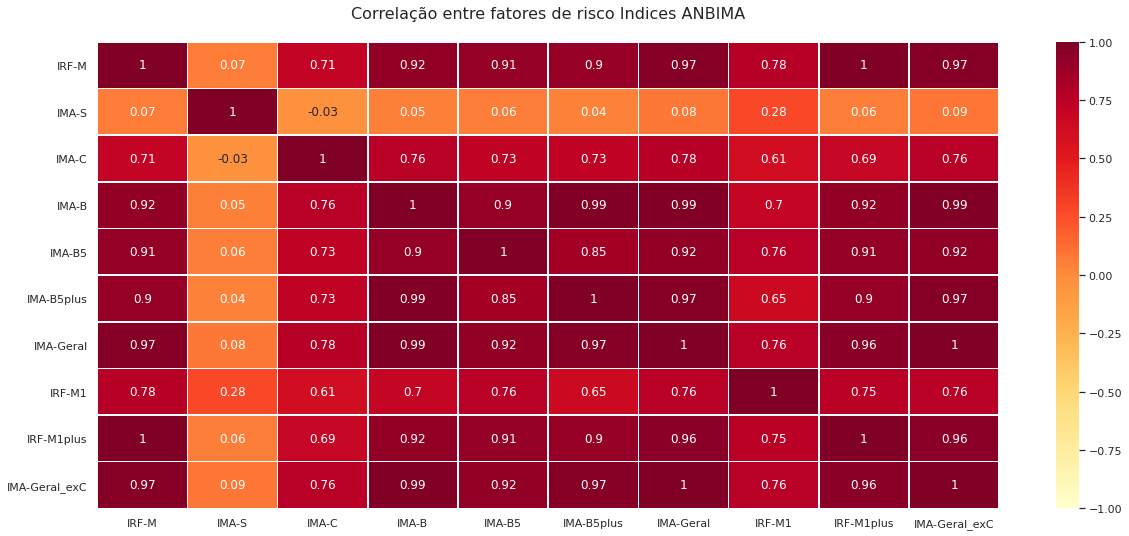

In [212]:
fat_anbima = ['IRF-M','IMA-S', 'IMA-C', 'IMA-B', 'IMA-B5','IMA-B5plus','IMA-Geral', 'IRF-M1', 'IRF-M1plus', 'IMA-Geral_exC' ]
A_anbima = df_return.loc[:,fat_anbima]

correl_fat_anbima = A_anbima.corr()

sns.set(rc={'figure.figsize':(18,8)})
color_scheme = 'YlOrRd'

mask = correl_fat_anbima.where(correl_fat_anbima != 0)#, NaN)
mask = mask.round(2)

ax = plt.axes();
sns.heatmap(mask, annot=True, cmap = color_scheme, linewidths=.5, vmin = -1, vmax = +1)

plt.title('Correlação entre fatores de risco Indices ANBIMA\n', fontsize = 16)
plt.show();


In [216]:
correl_fat_anbima.round(2)

IRF-M  IMA-S  IMA-C  IMA-B  IMA-B5  IMA-B5plus  IMA-Geral  \
IRF-M           1.00   0.07   0.71   0.92    0.91        0.90       0.97   
IMA-S           0.07   1.00  -0.03   0.05    0.06        0.04       0.08   
IMA-C           0.71  -0.03   1.00   0.76    0.73        0.73       0.78   
IMA-B           0.92   0.05   0.76   1.00    0.90        0.99       0.99   
IMA-B5          0.91   0.06   0.73   0.90    1.00        0.85       0.92   
IMA-B5plus      0.90   0.04   0.73   0.99    0.85        1.00       0.97   
IMA-Geral       0.97   0.08   0.78   0.99    0.92        0.97       1.00   
IRF-M1          0.78   0.28   0.61   0.70    0.76        0.65       0.76   
IRF-M1plus      1.00   0.06   0.69   0.92    0.91        0.90       0.96   
IMA-Geral_exC   0.97   0.09   0.76   0.99    0.92        0.97       1.00   

               IRF-M1  IRF-M1plus  IMA-Geral_exC  
IRF-M            0.78        1.00           0.97  
IMA-S            0.28        0.06           0.09  
IMA-C            0.61        0.69           0.76  
IMA-B            0.70        0.92           0.99  
IMA-B5           0.76        0.91           0.92  
IMA-B5plus       0.65        0.90           0.97  
IMA-Geral        0.76        0.96           1.00  
IRF-M1           1.00        0.75           0.76  
IRF-M1plus       0.75        1.00           0.96  
IMA-Geral_exC    0.76        0.96           1.00

# Seleciona um subconjunto dos 38 fatores de risco

## Fatores de risco escolhidos para o modelo

In [310]:
fat_risco_select = ['SP500', 'OIL_WTI', 
                    '10yr_Treasury',  '1yr_Treasury', 'BMF366_FUT1DOL366',
                    'BMF366_FUT3DOL366', 'GM366_ERV366','GM366_IBVSP366',
                     'IMA-S', 'IMA-B5','IMA-B5plus','IRF-M1', 'IRF-M1plus']
# IMA-B e IRF-M altamente correlacionados - estava dando problema na estimação - repetiva peso máximo na maioria dos fundos
# 'VIX', 'NASDAQ', 'Wilshire5000', '5yr_Treasury',  'GM366_EUROV366', 'GM366_IBVSPV366', 'IMA-C', 'IMA-B', 'IMA-B5','IMA-B5plus'] #'IRF-M1', 'IRF-M1plus' ,'IMA-C',

In [311]:
n = len(fat_risco_select)
print('Número de fatores de risco selecionados: ', n)

Número de fatores de risco selecionados:  13


In [312]:
A = df_return.loc[:,fat_risco_select]

#===============================================
# CRIA COLUNA DA CONSTANTE - alpha
#===============================================
A.insert(0, 'alpha', 1, allow_duplicates=False)
print(A.shape)
print('')
#print(A.columns)
print('')
#display(A.head(3))

(1016, 14)




In [313]:
# A é a Dataframe de retornos de fatores de risco e a constante
A.tail()

alpha     SP500   OIL_WTI  10yr_Treasury  1yr_Treasury  \
2021-02-12      1  0.004711  0.021986       0.034483     -0.142857   
2021-02-17      1 -0.000889  0.026723       0.075000      0.166667   
2021-02-18      1 -0.004416 -0.011295       0.000000     -0.142857   
2021-02-19      1 -0.001855 -0.021192       0.038760      0.166667   
2021-02-22      1 -0.007733  0.043133       0.022388     -0.142857   

            BMF366_FUT1DOL366  BMF366_FUT3DOL366  GM366_ERV366  \
2021-02-12           0.001287           0.003148      0.003524   
2021-02-17           0.005616           0.000000      0.006002   
2021-02-18           0.002799           0.004246      0.001847   
2021-02-19          -0.004960           0.000000     -0.005789   
2021-02-22           0.016362           0.017555      0.020770   

            GM366_IBVSP366  IMA-S  IMA-B5  IMA-B5plus  IRF-M1  IRF-M1plus  
2021-02-12       -0.000998    0.0     0.0         0.0     0.0         0.0  
2021-02-17        0.010408    0.0     0.0         0.0     0.0         0.0  
2021-02-18       -0.010102    0.0     0.0         0.0     0.0         0.0  
2021-02-19       -0.003290    0.0     0.0         0.0     0.0         0.0  
2021-02-22       -0.051201    0.0     0.0         0.0     0.0         0.0

## Correlação entre os fatores de risco selecionados

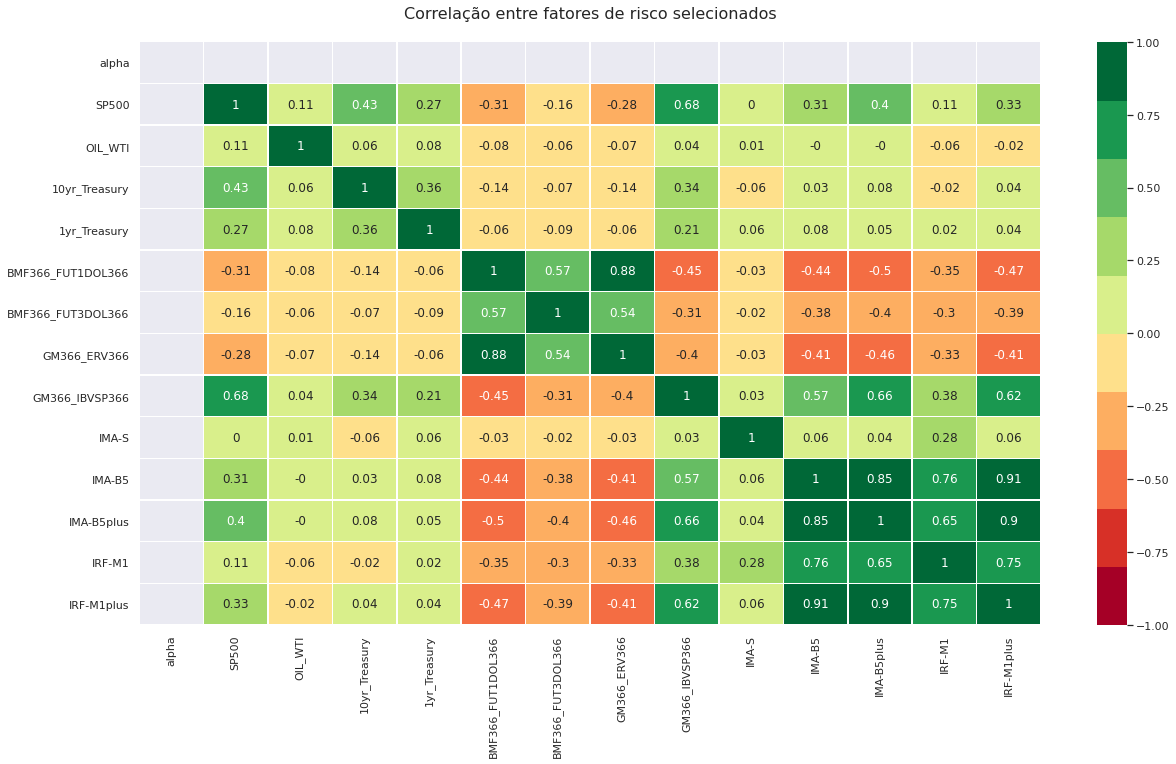

In [314]:
correl_fat_risco = A.corr()

sns.set(rc={'figure.figsize':(18,10)})
color_scheme =['#a50026','#d73027','#f46d43','#fdae61','#fee08b','#d9ef8b','#a6d96a','#66bd63','#1a9850','#006837']

mask = correl_fat_risco.where(correl_fat_risco != 0)#, NaN)
mask = mask.round(2)

ax = plt.axes();
sns.heatmap(mask, annot=True, cmap = color_scheme, linewidths=.5, vmin = -1, vmax = +1)

plt.title('Correlação entre fatores de risco selecionados\n', fontsize = 16)
plt.show();

# Calcula exposições para subconjunto de fundos que compõem o IHFA

In [315]:
print('Existem ', df_ihfa.shape[0], ' fundos na composição do IHFA')

Existem  257  fundos na composição do IHFA


## Calcula share acumulado dos fundos (estão em ordem decrescente de share no arquivo)

In [316]:
df_ihfa['cumsum_share'] = df_ihfa['share'].cumsum()

In [317]:
df_ihfa.head(10)

nome_fundo  \
0    IBIUNA HEDGE STH FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
1                                          KINEA CHRONOS FUNDO DE INVESTIMENTO MULTIMERCADO   
2     KAPITALO ZETA A FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
3  ABSOLUTE VERTEX II FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
4    SAFRA GALILEO AG FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
5                                          SANTANDER ACTIVE PORTFOLIO MULT CRÉD PRIV FIC FI   
6                                         KINEA ATLAS II FUNDO DE INVESTIMENTO MULTIMERCADO   
7             GROWLER FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
8        ADAM MACRO 1 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
9        OCCAM RETORNO ABSOLUTO ADVISORY FI EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   

                 CNPJ  PL_20210114  share  cumsum_share  
0  15.799.713/0001-34      7689.38   4.44          4.44  
1  21.624.757/0001-26      6468.96   3.69          8.13  
2  20.270.180/0001-39      3780.37   2.21         10.34  
3  23.565.803/0001-99      3403.30   1.97         12.31  
4  27.249.881/0001-35      3178.35   1.81         14.12  
5  29.549.588/0001-19      2945.41   1.69         15.81  
6  29.762.315/0001-58      2764.55   1.57         17.38  
7  18.489.908/0001-76      2588.84   1.51         18.89  
8  24.119.419/0001-25      2600.20   1.49         20.38  
9  34.475.592/0001-10      2489.02   1.45         21.83

In [299]:
df_ihfa.iloc[45:50,:]

nome_fundo  \
45                       CSHG VERDE FUNDO DE INVESTIMENTO EM COTAS DE FUNDO DE INVESTIMENTO MULTIMERCADO   
46                  PACIFICO MACRO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO   
47                    SAFARI 45 FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO MULTIMERCADO II   
48  CSHG MASTER GOLD ATIVO II FUNDO DE INVESTIMENTO MULTIMERCADO - CREDITO PRIVADO INVESTIMENTO NO EXTER   
49                                              SAFRA GLOBAL EQUITIES FUNDO DE INVESTIMENTO MULTIMERCADO   

                  CNPJ  PL_20210114  share  cumsum_share  
45  01.221.890/0001-24      1083.69   0.63         54.87  
46  22.354.046/0001-41      1070.22   0.62         55.49  
47  31.533.638/0001-11      1024.80   0.62         56.11  
48  31.525.221/0001-07      1094.96   0.61         56.72  
49  19.226.446/0001-67      1061.71   0.61         57.33

## Otimização para cada uma das colunas - acha os fatores de risco para cada um dos fundos

In [319]:
def acha_peso_fat_risco_long_short(A, bval, perc_maximo = 0.50, perc_minimo = -0.50):
    ''' Acha os pesos de cada um dos fatores de risco para um dado fundo
        Calcula usando apenas as datas que não tem valores nan
        Inputs: A = dataframe cujas colunas são os retornos diários dos fatores de risco
        perc_maximo = percentual máximo que poderá ser alocado num fator de risco
        bval = retornos diários do fundo de interesse, np.array
        
        Os pesos encontrados aqui são sujeitos às restrições: -0.50 <= x <= 0.50 e soma(x) = 1'''
    #========================================================================
    # Verifica quantos nan existem no array de retornos e cria array sem nan
    #========================================================================
    print('comprimento do vetor de retornos:' , len(bval))

    m = sum(np.isnan(bval))
    print('quantidade de nan no vetor de retornos:' , m)

    bval_sem_nan = bval[m+1:]
    #bval_sem_nan
    #print(sum(np.isnan(bval_sem_nan)))
    print('comprimento do vetor de retornos SEM nan:' , len(bval_sem_nan))
    #========================================================================
    # Restringe A para o mesmo comprimento de bval_sem_nan
    #========================================================================
    A_sem_nan = A.copy()
    #print(A_sem_nan.shape)

    A_sem_nan = A_sem_nan.iloc[m+1:]  # seleciona desde a linha m+1 até o final, supõe que nan no início
    print(A_sem_nan.shape)

    #display(A_sem_nan)
    
    ####AA = A.values # AA é um numpy array criado a partir da dataframe A
    AA_sem_nan = A_sem_nan.values
    
    import cvxpy as cp
    x = cp.Variable(n + 1)  # Pesos - inclui constante
    # Função objetivo - minimiza SSResíduos (sujeita às restrições)
    objective = cp.Minimize(cp.sum_squares(AA_sem_nan@x - bval_sem_nan))
    #objective = cp.Minimize(cp.sum_squares(AA@x - bval))   # AA é um numpy array criado a partir da dataframe A
    constraints = [x >= perc_minimo, x <= perc_maximo, sum(x) == 1]  # soma dos pesos = 1
    # Define o problema de otimização
    prob = cp.Problem(objective, constraints)  # Valor ótimo da função objetivo - o ideal é zero!
    # Valor ótimo da função objetivo
    result = prob.solve()
    print('Valor da função objetivo que foi minimizada:   ',round(result,6))
    print('')
    # Valor ótimo dos pesos
    return x.value

# Otimização para sequência de fundos em df_ihfa

## Roda para os nc maiores (nc inputado pelo usuário, default = 10)

In [343]:
nc = int(input('**** Entre com o número de fundos a analisar (default = 10 maiores):***** ') or 10)

nome_coluna_select = []

for f in df_ihfa.CNPJ[0:nc]:
    #print(f)  
    #npj_fundo_select= df_ihfa.iloc[0,1]
    #cnpj_fundo_select
    add_nome = 'ret_'+ f  #fundo_select
    nome_coluna_select.append(add_nome)
    #print(nome_coluna_select)
    
    bbb = df_return.loc[:, nome_coluna_select]
    bbb = bbb.squeeze()
    bbbval = bbb.values
    

**** Entre com o número de fundos a analisar (default = 10 maiores):***** 257


In [344]:
time_start = perf_counter()

show_pesos = pd.DataFrame()

pmax = float(input('Entre com o percentual máximo a ser alocado num fator de risco (default = 0.4): ') or 0.40)
print(pmax)

print('')
pmin = float(input('Entre com o percentual mínimo (<0) a ser alocado num fator de risco (default = 0): ') or 0.0)
print(pmin)

for j in bbb.columns:
    #print('')
    #print(j)
    show_pesos[j] = 100.0*acha_peso_fat_risco_long_short(A, bbb[j], float(pmax), float(pmin)).round(4);#bval)

    show_pesos = show_pesos.set_index(pd.Series(A.columns.to_list()))

#uu1 = pd.Series(A.columns.to_list())
#uu2 = pd.Series(100.0*x.value.round(6))
#show_pesos = pd.DataFrame(columns = [uu1,uu2])
#d = {'fat_risco':uu1, 'peso': uu2}
#show_pesos = pd.DataFrame(d)
#show_pesos = show_pesos.set_index('fat_risco')
display(show_pesos)
#show_pesos.sort_values('peso', ascending = False).head(7)

time_end = perf_counter()
elapsed_time = time_end - time_start
print(' ****Otimização (long e short) para '+str(bbb.shape[1]) + ' fundos demorou', round(elapsed_time,2) , ' segundos *****')

Entre com o percentual máximo a ser alocado num fator de risco (default = 0.4): 0.35
0.35

Entre com o percentual mínimo (<0) a ser alocado num fator de risco (default = 0): 0
0.0
comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.017155

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.001603

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.024902

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.011765

comprimento do vetor de retornos

/opt/conda/lib/python3.8/site-packages/cvxpy/problems/problem.py:1245: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Valor da função objetivo que foi minimizada:    0.004871

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 324
comprimento do vetor de retornos SEM nan: 691
(691, 14)
Valor da função objetivo que foi minimizada:    0.003379

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.008272

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.010795

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 727
comprimento do vetor de retornos SEM nan: 288
(288, 14)
Valor da função objetivo que foi minimizada:    0.002471

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função

Valor da função objetivo que foi minimizada:    0.00955

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.003907

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 373
comprimento do vetor de retornos SEM nan: 642
(642, 14)
Valor da função objetivo que foi minimizada:    0.011355

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.021489

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 311
comprimento do vetor de retornos SEM nan: 704
(704, 14)
Valor da função objetivo que foi minimizada:    0.017956

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 595
comprimento do vetor de retornos SEM nan: 420
(420, 14)
Valor da função 

Valor da função objetivo que foi minimizada:    0.004133

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 129
comprimento do vetor de retornos SEM nan: 886
(886, 14)
Valor da função objetivo que foi minimizada:    0.003908

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.063835

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.017008

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.02287

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função 

Valor da função objetivo que foi minimizada:    0.012698

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.005513

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.025245

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 509
comprimento do vetor de retornos SEM nan: 506
(506, 14)
Valor da função objetivo que foi minimizada:    0.018326

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.004301

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 281
comprimento do vetor de retornos SEM nan: 734
(734, 14)
Valor da função

Valor da função objetivo que foi minimizada:    0.008454

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 568
comprimento do vetor de retornos SEM nan: 447
(447, 14)
Valor da função objetivo que foi minimizada:    0.003637

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.009035

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 614
comprimento do vetor de retornos SEM nan: 401
(401, 14)
Valor da função objetivo que foi minimizada:    0.008141

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.007812

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função

Valor da função objetivo que foi minimizada:    0.004425

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 697
comprimento do vetor de retornos SEM nan: 318
(318, 14)
Valor da função objetivo que foi minimizada:    0.00271

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 395
comprimento do vetor de retornos SEM nan: 620
(620, 14)
Valor da função objetivo que foi minimizada:    0.023648

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 238
comprimento do vetor de retornos SEM nan: 777
(777, 14)
Valor da função objetivo que foi minimizada:    0.038712

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 0
comprimento do vetor de retornos SEM nan: 1015
(1015, 14)
Valor da função objetivo que foi minimizada:    0.00662

comprimento do vetor de retornos: 1016
quantidade de nan no vetor de retornos: 302
comprimento do vetor de retornos SEM nan: 713
(713, 14)
Valor da função o

ret_15.799.713/0001-34  ret_21.624.757/0001-26  \
alpha                                0.01                   -0.00   
SP500                               -0.00                    0.66   
OIL_WTI                             -0.00                    0.02   
10yr_Treasury                       -0.00                    0.35   
1yr_Treasury                        -0.00                   -0.00   
BMF366_FUT1DOL366                    0.00                   -0.00   
BMF366_FUT3DOL366                   -0.00                    0.00   
GM366_ERV366                         0.00                    0.00   
GM366_IBVSP366                      -0.00                    3.08   
IMA-S                                0.00                   28.45   
IMA-B5                              35.00                   24.34   
IMA-B5plus                          16.80                    6.97   
IRF-M1                              13.18                   35.00   
IRF-M1plus                          35.00                    1.12   

                   ret_20.270.180/0001-39  ret_23.565.803/0001-99  \
alpha                                0.00                    0.01   
SP500                                5.58                    0.00   
OIL_WTI                              0.38                    0.07   
10yr_Treasury                       -0.00                    0.00   
1yr_Treasury                         0.00                    0.00   
BMF366_FUT1DOL366                   -0.00                    0.00   
BMF366_FUT3DOL366                   -0.00                    0.00   
GM366_ERV366                        -0.00                    0.00   
GM366_IBVSP366                      17.17                    6.66   
IMA-S                               -0.00                    7.02   
IMA-B5                              35.00                   35.00   
IMA-B5plus                          21.34                    7.72   
IRF-M1                               9.02                   35.00   
IRF-M1plus                          11.52                    8.52   

                   ret_27.249.881/0001-35  ret_29.549.588/0001-19  \
alpha                               -0.00                   -0.00   
SP500                               -0.00                   13.86   
OIL_WTI                              0.00                    0.00   
10yr_Treasury                       -0.00                    0.12   
1yr_Treasury                         0.00                    0.16   
BMF366_FUT1DOL366                    1.41                    2.72   
BMF366_FUT3DOL366                   -0.00                   -0.00   
GM366_ERV366                         3.55                   -0.00   
GM366_IBVSP366                      11.04                   18.12   
IMA-S                                2.51                   25.13   
IMA-B5                              35.00                   10.34   
IMA-B5plus                           0.00                   24.81   
IRF-M1                              35.00                   -0.00   
IRF-M1plus                          11.49                    4.74   

                   ret_29.762.315/0001-58  ret_18.489.908/0001-76  \
alpha                               -0.00                    0.00   
SP500                                1.07                    2.32   
OIL_WTI                              0.03                   -0.00   
10yr_Treasury                        0.14                    0.83   
1yr_Treasury                         0.00                   -0.00   
BMF366_FUT1DOL366                   -0.00                    4.52   
BMF366_FUT3DOL366                   -0.00                    2.13   
GM366_ERV366                        -0.00                    0.00   
GM366_IBVSP366                       7.60                    0.00   
IMA-S                               11.73                   35.00   
IMA-B5                              35.00                   11.79   
IMA-B5plus                           9.43                    8.41   
IRF-M1        

 ****Otimização (long e short) para 257 fundos demorou 77.75  segundos *****


In [345]:
nc ### numero de colunas

257

In [346]:
show_pesos2= show_pesos.copy()

# Usa apenas os 30 primeiros caracteres do nome de cada fundo
show_pesos2.columns = df_ihfa['nome_fundo'].str[:30][0:nc]
show_pesos2

nome_fundo         IBIUNA HEDGE STH FUNDO DE INVE  \
alpha                                        0.01   
SP500                                       -0.00   
OIL_WTI                                     -0.00   
10yr_Treasury                               -0.00   
1yr_Treasury                                -0.00   
BMF366_FUT1DOL366                            0.00   
BMF366_FUT3DOL366                           -0.00   
GM366_ERV366                                 0.00   
GM366_IBVSP366                              -0.00   
IMA-S                                        0.00   
IMA-B5                                      35.00   
IMA-B5plus                                  16.80   
IRF-M1                                      13.18   
IRF-M1plus                                  35.00   

nome_fundo         KINEA CHRONOS FUNDO DE INVESTI  \
alpha                                       -0.00   
SP500                                        0.66   
OIL_WTI                                      0.02   
10yr_Treasury                                0.35   
1yr_Treasury                                -0.00   
BMF366_FUT1DOL366                           -0.00   
BMF366_FUT3DOL366                            0.00   
GM366_ERV366                                 0.00   
GM366_IBVSP366                               3.08   
IMA-S                                       28.45   
IMA-B5                                      24.34   
IMA-B5plus                                   6.97   
IRF-M1                                      35.00   
IRF-M1plus                                   1.12   

nome_fundo         KAPITALO ZETA A FUNDO DE INVES  \
alpha                                        0.00   
SP500                                        5.58   
OIL_WTI                                      0.38   
10yr_Treasury                               -0.00   
1yr_Treasury                                 0.00   
BMF366_FUT1DOL366                           -0.00   
BMF366_FUT3DOL366                           -0.00   
GM366_ERV366                                -0.00   
GM366_IBVSP366                              17.17   
IMA-S                                       -0.00   
IMA-B5                                      35.00   
IMA-B5plus                                  21.34   
IRF-M1                                       9.02   
IRF-M1plus                                  11.52   

nome_fundo         ABSOLUTE VERTEX II FUNDO DE IN  \
alpha                                        0.01   
SP500                                        0.00   
OIL_WTI                                      0.07   
10yr_Treasury                                0.00   
1yr_Treasury                                 0.00   
BMF366_FUT1DOL366                            0.00   
BMF366_FUT3DOL366                            0.00   
GM366_ERV366                                 0.00   
GM366_IBVSP366                               6.66   
IMA-S                                        7.02   
IMA-B5                                      35.00   
IMA-B5plus                                   7.72   
IRF-M1                                      35.00   
IRF-M1plus                                   8.52   

nome_fundo         SAFRA GALILEO AG FUNDO DE INVE  \
alpha                                       -0.00   
SP500                                       -0.00   
OIL_WTI                                      0.00   
10yr_Treasury                               -0.00   
1yr_Treasury                                 0.00   
BMF366_FUT1DOL366                            1.41   
BMF366_FUT3DOL366                           -0.00   
GM366_ERV366                                 3.55   
GM366_IBVSP366                              11.04   
IMA-S                                        2.51   
IMA-B5                                      35.00   
IMA-B5plus                                   0.00   
IRF-M1                                      35.00   
IRF-M1plus                                  11.49   

nome_fundo         S

## Heatmap dos pesos estimados

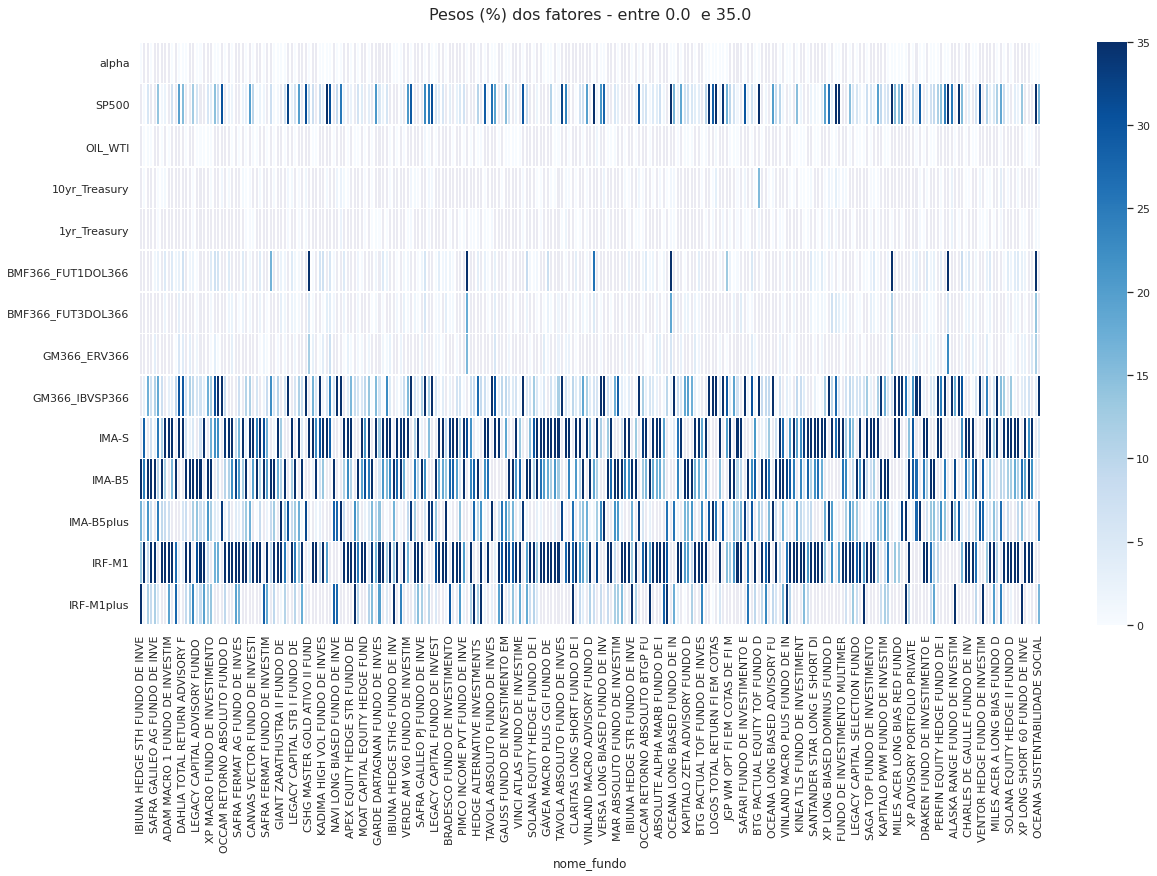

In [347]:
sns.set(rc={'figure.figsize':(18,10)})
#color_scheme = ['#d73027','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850']
#color_scheme = ['#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
#color_scheme =['#a50026','#d73027','#f46d43','#fdae61','#fee08b','#d9ef8b','#a6d96a','#66bd63','#1a9850','#006837']
color_scheme = 'Blues'
mask = show_pesos2.where(show_pesos2 != 0)#, NaN)
mask = mask.round(2)

ax = plt.axes();
sns.heatmap(mask, annot=False, cmap = color_scheme, linewidths=.5, vmin = 100.0*pmin, vmax = 100.0*pmax); #annot=True
#ax.set_title('Pesos (%) dos fatores - '+ 'entre '+str(100*pmin)+ '  e '+str(100*pmax)+'\n');
plt.title('Pesos (%) dos fatores - '+ 'entre '+str(100*pmin)+ '  e '+str(100*pmax)+'\n', fontsize = 16)
plt.show();

In [342]:
show_pesos2.loc[:,'GIANT ZARATHUSTRA FUNDO DE INV']

alpha                 0.01
SP500                 0.00
OIL_WTI              -0.00
10yr_Treasury         0.00
1yr_Treasury         -0.00
BMF366_FUT1DOL366     1.89
BMF366_FUT3DOL366     3.42
GM366_ERV366          0.00
GM366_IBVSP366        0.00
IMA-S                 9.76
IMA-B5               13.17
IMA-B5plus           35.00
IRF-M1               35.00
IRF-M1plus            1.76
Name: GIANT ZARATHUSTRA FUNDO DE INV, dtype: float64

In [350]:
time_start = perf_counter()

show_pesos2.to_pickle('pesos_fatores_min_percentage_'+str(pmin) +'_max_percentage_'+str(pmax)+'_top_'+str(bbb.shape[1])+'_fundos_'+dd+'.pkl')
show_pesos2.to_csv('pesos_fatores_min_percentage_'+str(pmin) +'_max_percentage_'+str(pmax)+'_top_'+str(bbb.shape[1])+'_fundos_'+dd+'.csv',sep = ';' ,encoding='utf-8') 

time_end = perf_counter()
elapsed_time = time_end - time_start
print(' ****salvar FATORES DE RISCO demorou', round(elapsed_time,2) , ' segundos *****')

 ****salvar FATORES DE RISCO demorou 0.33  segundos *****


# Correlação entre os retornos dos fundos selecionados no ihfa

In [352]:
df_return2 =  df_return.loc[:,bbb.columns.to_list()].round(4).copy()
df_return2.columns = df_ihfa['nome_fundo'].str[:30][0:nc]   
#display(df_return2)

ret_corr = df_return2.corr()
display(ret_corr)

nome_fundo                      IBIUNA HEDGE STH FUNDO DE INVE  \
nome_fundo                                                       
IBIUNA HEDGE STH FUNDO DE INVE                        1.000000   
KINEA CHRONOS FUNDO DE INVESTI                        0.584069   
KAPITALO ZETA A FUNDO DE INVES                        0.616430   
ABSOLUTE VERTEX II FUNDO DE IN                        0.783509   
SAFRA GALILEO AG FUNDO DE INVE                        0.568774   
...                                                        ...   
XP LONG SHORT 60 FUNDO DE INVE                        0.123235   
BTG PACTUAL MULTISTRATEGIES AD                        0.510218   
HOD MULTIPLICA HIGH YIELD 360                        -0.026825   
M SQUARE GLOBAL EQUITY MANAGER                       -0.102592   
OCEANA SUSTENTABILIDADE SOCIAL                        0.311021   

nome_fundo                      KINEA CHRONOS FUNDO DE INVESTI  \
nome_fundo                                                       
IBIUNA HEDGE STH FUNDO DE INVE                        0.584069   
KINEA CHRONOS FUNDO DE INVESTI                        1.000000   
KAPITALO ZETA A FUNDO DE INVES                        0.712087   
ABSOLUTE VERTEX II FUNDO DE IN                        0.614004   
SAFRA GALILEO AG FUNDO DE INVE                        0.576313   
...                                                        ...   
XP LONG SHORT 60 FUNDO DE INVE                        0.246401   
BTG PACTUAL MULTISTRATEGIES AD                        0.626447   
HOD MULTIPLICA HIGH YIELD 360                         0.021454   
M SQUARE GLOBAL EQUITY MANAGER                       -0.005225   
OCEANA SUSTENTABILIDADE SOCIAL                        0.661366   

nome_fundo                      KAPITALO ZETA A FUNDO DE INVES  \
nome_fundo                                                       
IBIUNA HEDGE STH FUNDO DE INVE                        0.616430   
KINEA CHRONOS FUNDO DE INVESTI                        0.712087   
KAPITALO ZETA A FUNDO DE INVES                        1.000000   
ABSOLUTE VERTEX II FUNDO DE IN                        0.666361   
SAFRA GALILEO AG FUNDO DE INVE                        0.601439   
...                                                        ...   
XP LONG SHORT 60 FUNDO DE INVE                        0.233651   
BTG PACTUAL MULTISTRATEGIES AD                        0.744167   
HOD MULTIPLICA HIGH YIELD 360                        -0.023940   
M SQUARE GLOBAL EQUITY MANAGER                        0.107932   
OCEANA SUSTENTABILIDADE SOCIAL                        0.623546   

nome_fundo                      ABSOLUTE VERTEX II FUNDO DE IN  \
nome_fundo                                                       
IBIUNA HEDGE STH FUNDO DE INVE                        0.783509   
KINEA CHRONOS FUNDO DE INVESTI                        0.614004   
KAPITALO ZETA A FUNDO DE INVES                        0.666361   
ABSOLUTE VERTEX II FUNDO DE IN                        1.000000   
SAFRA GALILEO AG FUNDO DE INVE                        0.562636   
...                                                        ...   
XP LONG SHORT 60 FUNDO DE INVE                        0.215100   
BTG PACTUAL MULTISTRATEGIES AD                        0.550591   
HOD MULTIPLICA HIGH YIELD 360                        -0.144716   
M SQUARE GLOBAL EQUITY MANAGER                       -0.046250   
OCEANA SUSTENTABILIDADE SOCIAL                        0.408439   

nome_fundo                      SAFRA GALILEO AG FUNDO DE INVE  \
nome_fundo                                                       
IBIUNA HEDGE STH FUNDO DE INVE                        0.568774   
KINEA CHRONOS FUNDO DE INVESTI                        0.576313   
KAPITALO ZETA A FUNDO DE INVES                        0.601439   
ABSOLUTE VERTEX II FUNDO DE IN                        0.562636   
SAFRA GALILEO AG FUNDO DE INVE                        1.000000   
...                                                        ...   
XP LONG SHORT 60 FUNDO DE INVE      

# Fundos com alta correlação positiva (> +0.8)

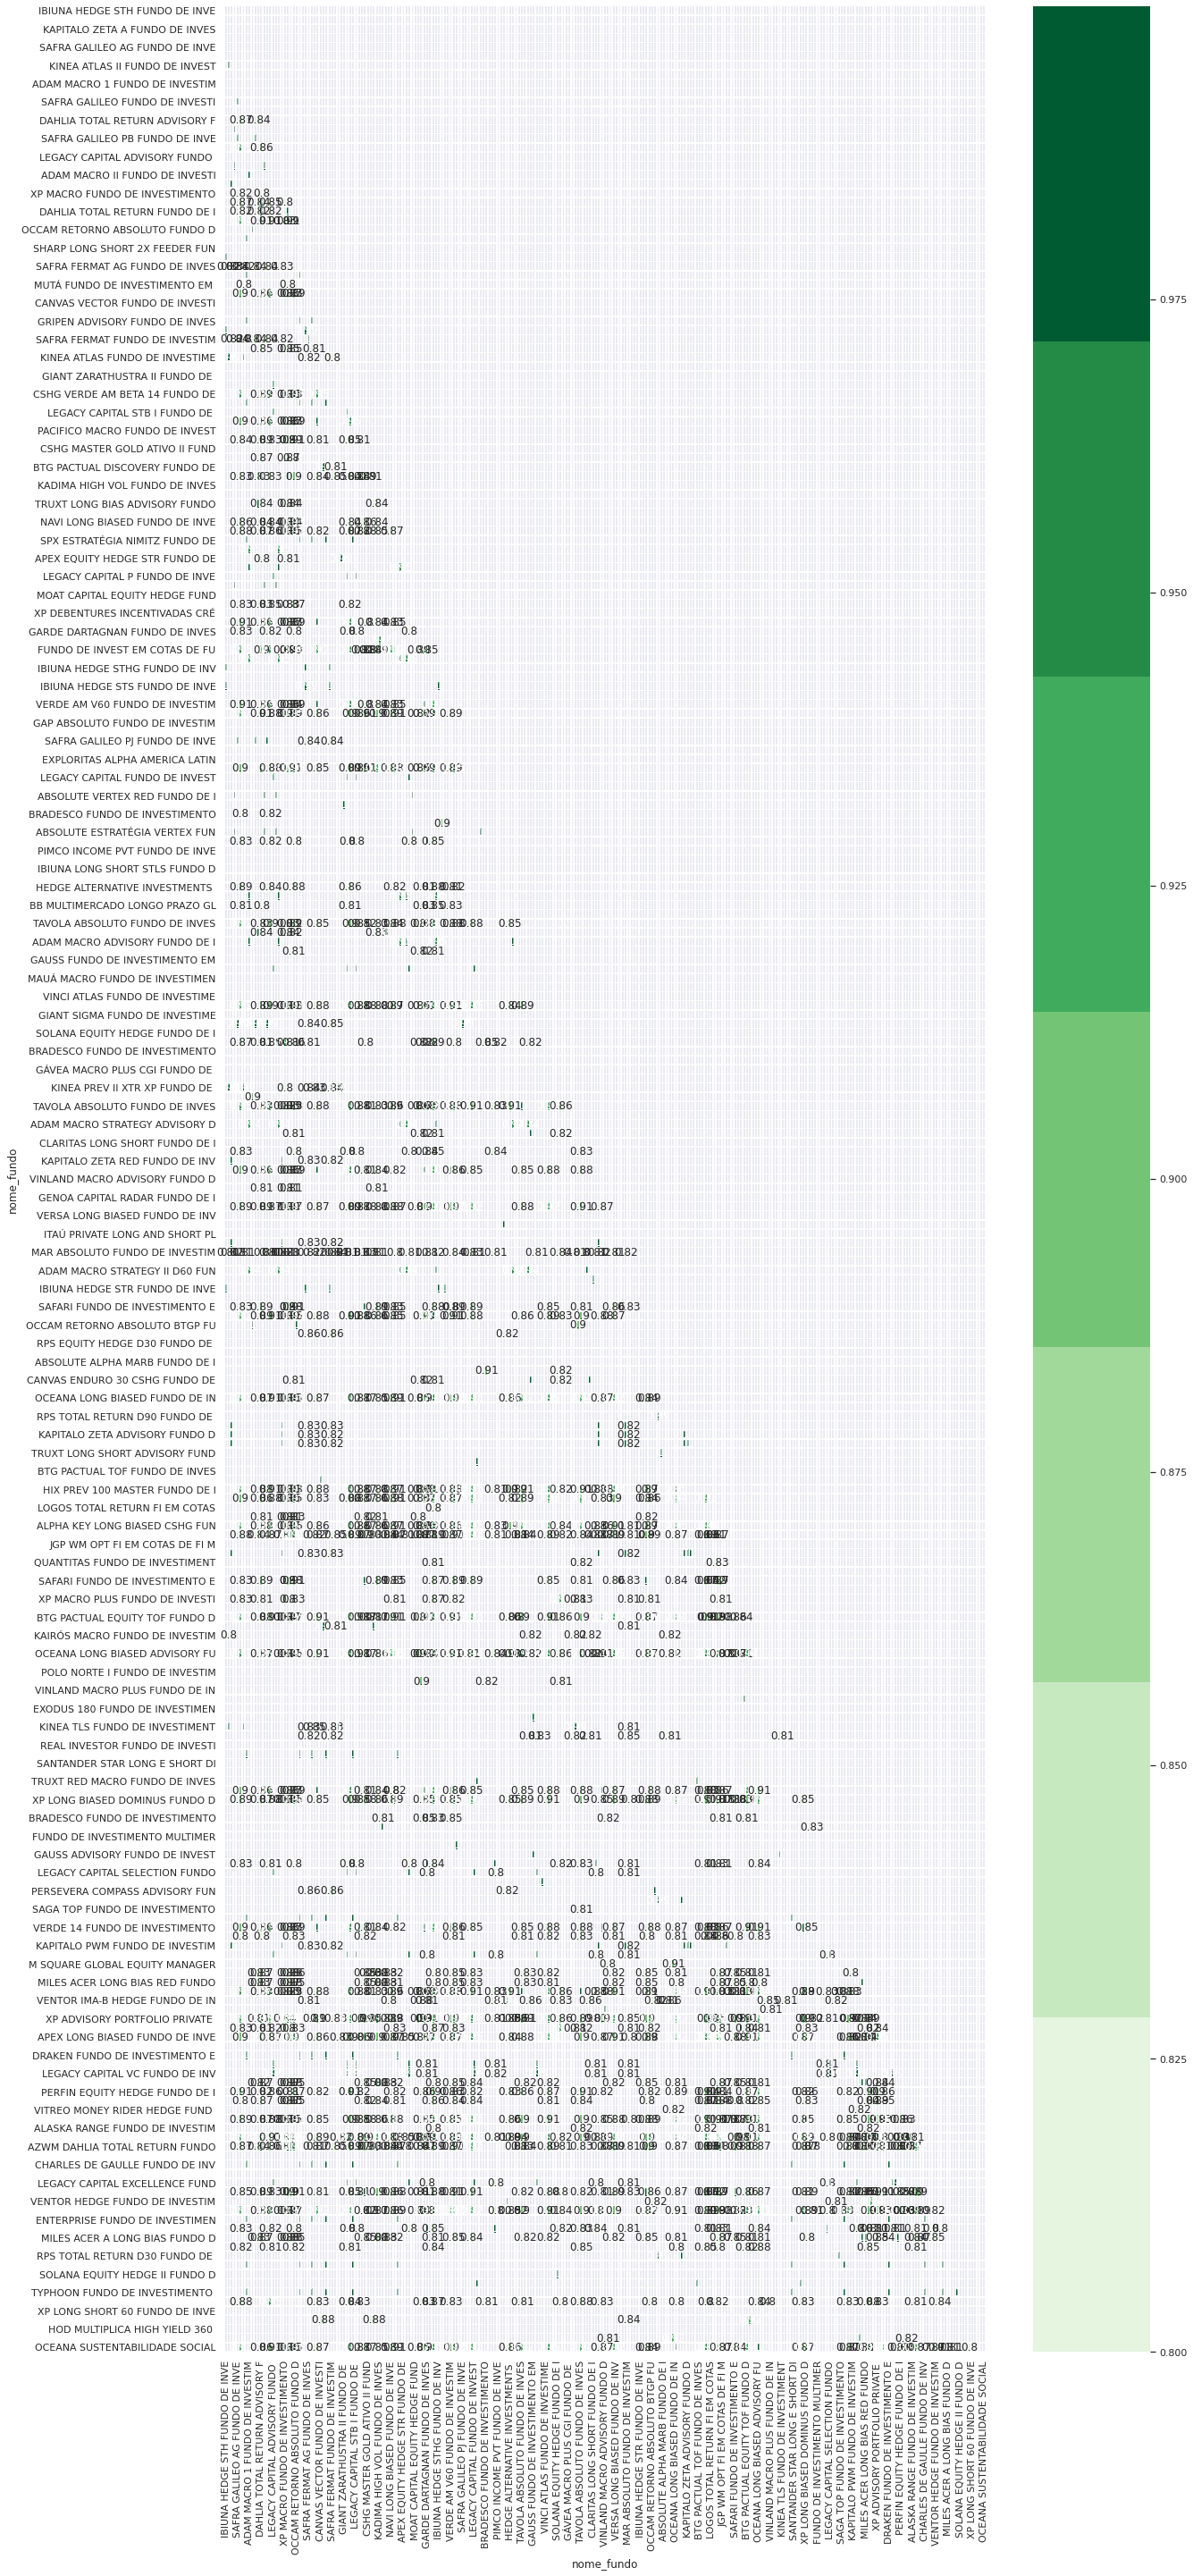

In [354]:
ret_corr2 = ret_corr.where(ret_corr>=+0.8,  inplace=False, axis=None, level=None, errors='raise')

sns.set(rc={'figure.figsize':(17,45)})
#color_scheme = ['#d73027','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850']
color_scheme = ['#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(ret_corr2, dtype=bool))

#color_scheme = color_scheme[::-1]  # Reverte a ordem dos eleventos da lista de cores
#print(color_scheme)
sns.heatmap(ret_corr2, mask = mask, annot=True, cmap = color_scheme, linewidths=.5, vmin = +0.8);
#plt.show()

# Fundos com baixa correlação (< +0.1)

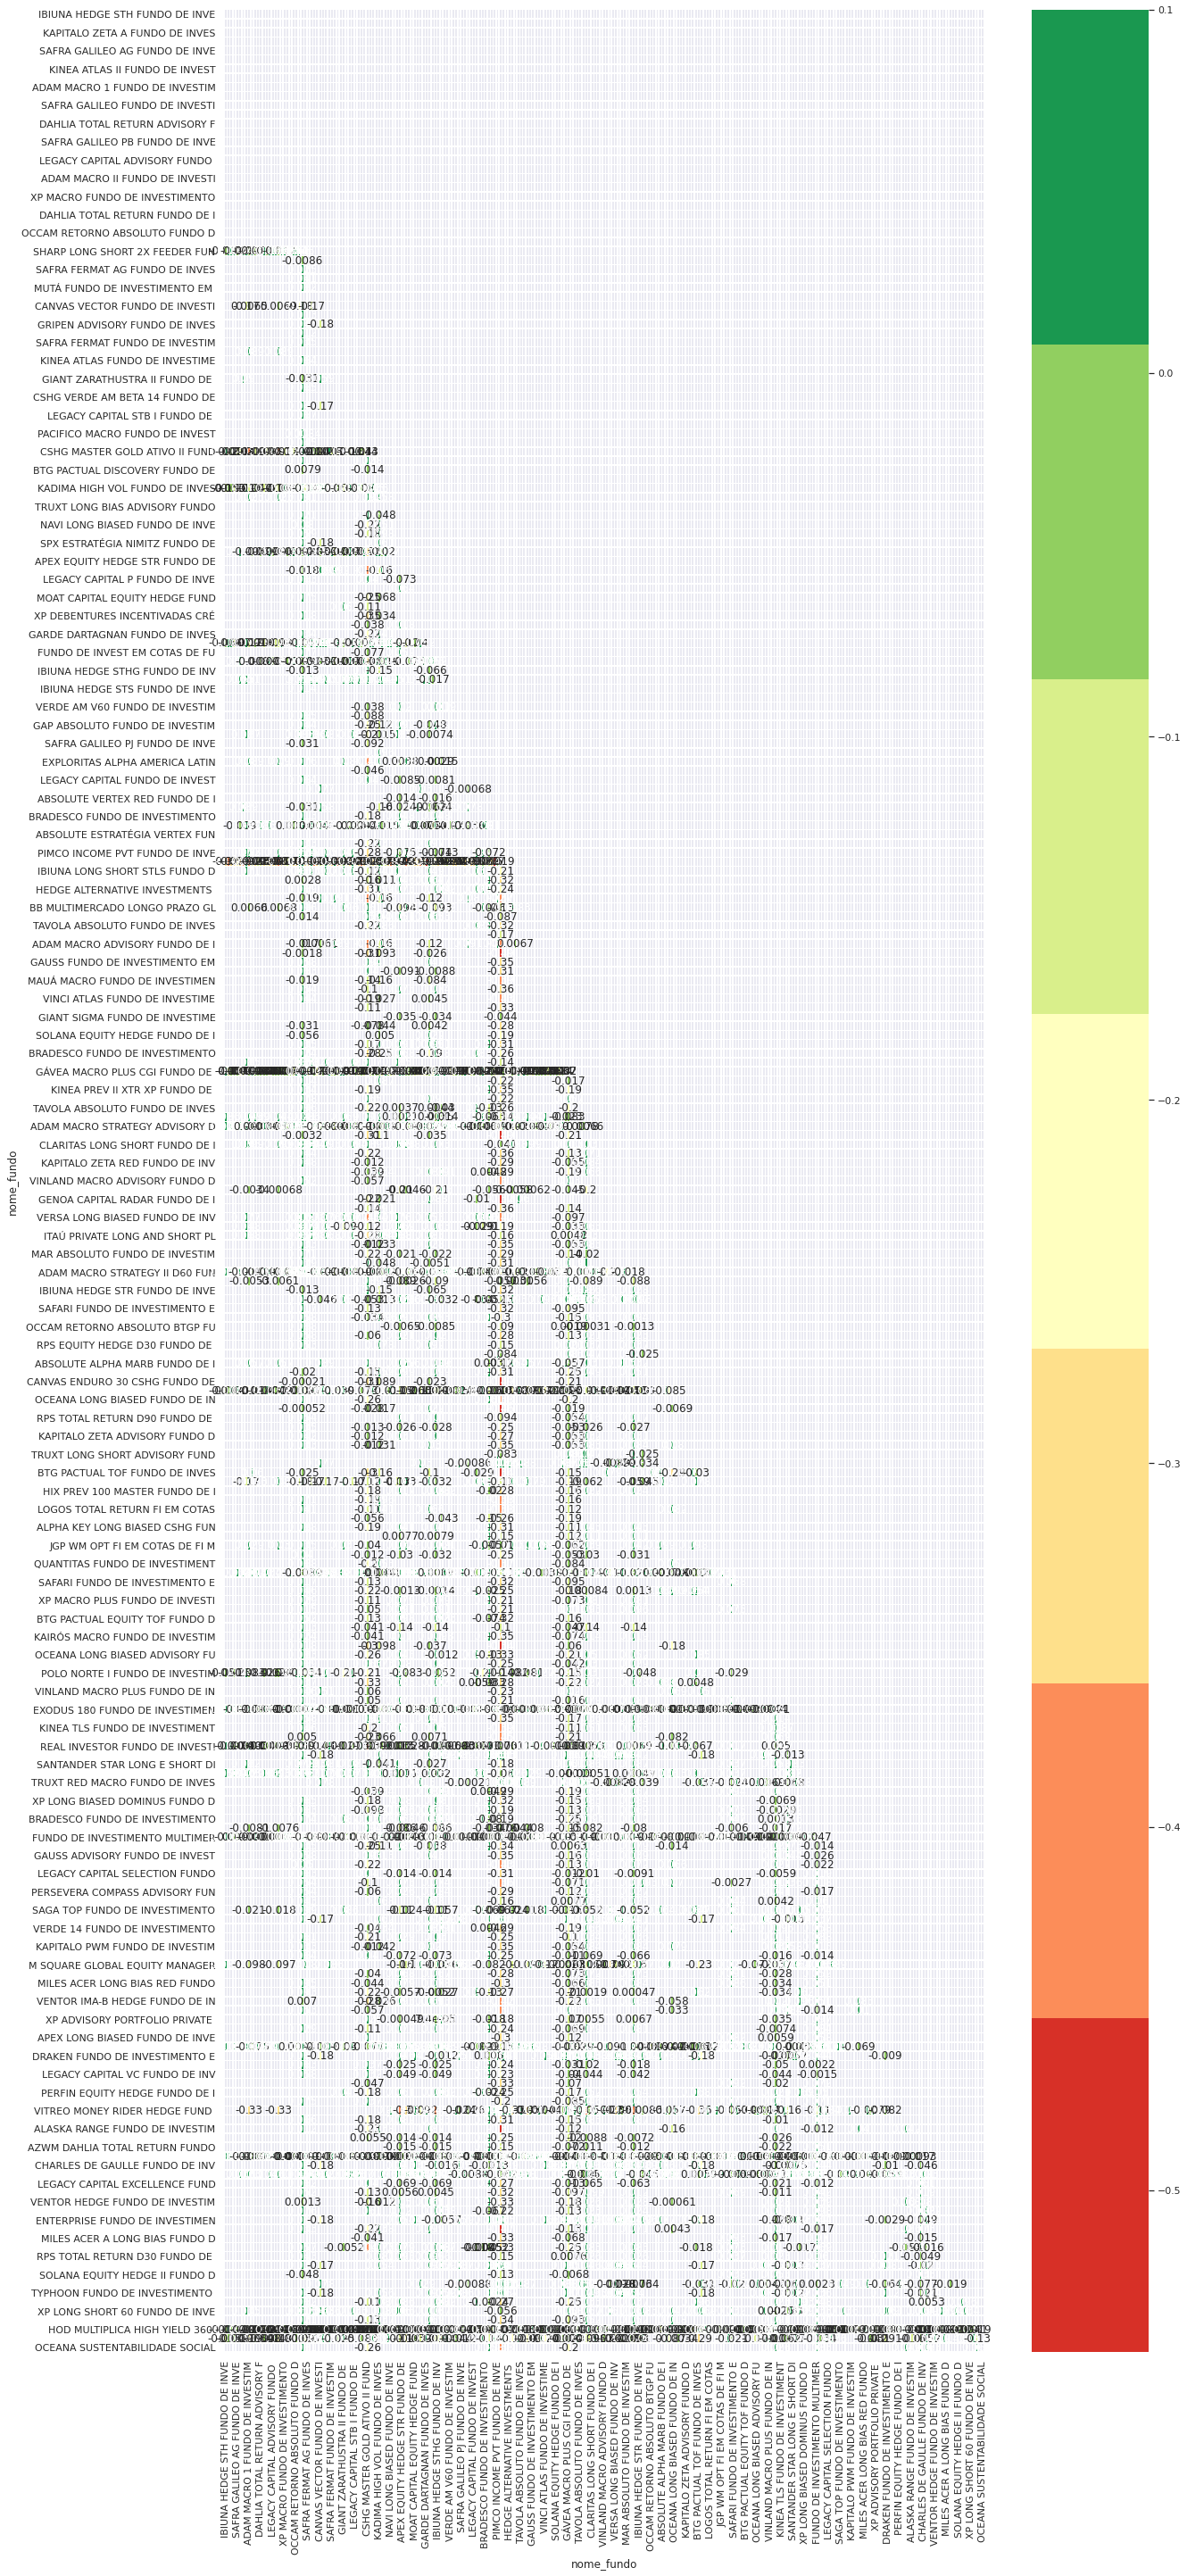

In [355]:
ret_corr2 = ret_corr.where(ret_corr<=+0.1,  inplace=False, axis=None, level=None, errors='raise')

sns.set(rc={'figure.figsize':(17,45)})
color_scheme = ['#d73027','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850']
#color_scheme = ['#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(ret_corr2, dtype=bool))

#color_scheme = color_scheme[::-1]  # Reverte a ordem dos eleventos da lista de cores
#print(color_scheme)
sns.heatmap(ret_corr2, mask = mask, annot=True, cmap = color_scheme, linewidths=.5, vmax = +0.1);
#plt.show()

# Fundos ALTAMENTE correlacionados (corr >  0.95)

In [ ]:
ret_corr2 = ret_corr.where(ret_corr >= +0.95,  inplace=False, axis=None, level=None, errors='raise')

sns.set(rc={'figure.figsize':(20,65)})
#color_scheme = ['#d73027','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850']
#color_scheme = ['#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
color_scheme = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(ret_corr2, dtype=bool))

#color_scheme = color_scheme[::-1]  # Reverte a ordem dos eleventos da lista de cores
#print(color_scheme)
sns.heatmap(ret_corr2, mask = mask, annot=True, cmap = color_scheme, linewidths=.5);
#plt.show()